# Notes

I actually extended the class and add some functionalities to help me visualize the steps.

Also this Maze class fails on my **Python 2** due to some unicode-related issues (mostly with unicode.isnumeric()). I fixed some parts involved in this issue and I think it should run well in **Python 3**, but I'm not sure.

The MCTS training for maze7() is **very slow**, use **PyPy** for better performance.

------

First, we load up some useful libraries for visualization and data structures.

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.axes as axes
import copy
import random

Next we need a Maze class for pathfinding. It will help to have read the RedBlobGames [A\* tutorial](http://www.redblobgames.com/pathfinding/a-star/introduction.html) before continuing.

These Mazes are defined in ASCII diagrams and can have walls ("#"), empty spaces ("."), switches (numbers), and doors (letters; closed are uppercase). The "0" switch toggles the open status of all the "a" doors, "1" goes to the "b" doors, etc. Mazes can also contain pits: "?" pits have a 30% chance of killing the player and "!" pits have a 60% chance. Every maze has one player start location "@" and one goal square "X". Walls and closed doors block movement.

[(1, 0), (0, -1), (0, 1), 'switch']


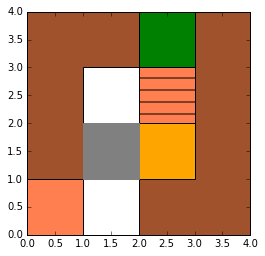

In [2]:
class Maze:
    
    SwitchMap = {"0":"a", "1":"b", "2":"c", "3":"d", "4":"e", "5":"f", "6":"g", "7":"h", "8":"i", "9":"j"}
    Colors = {"a":"coral","b":"tan","c":"palegreen","d":"blue","e":"cyan","f":"magenta","g":"yellow","h":"olive","i":"purple","j":"darkgreen",
              "0":"coral","1":"tan","2":"palegreen","3":"blue","4":"cyan","5":"magenta","6":"yellow","7":"olive","8":"purple","9":"darkgreen",
             "?":"orange",
             "!":"red",
             "x":"green","@":"gray",
             "#":"sienna",".":"white",
             "p":"blue" # For paths
             }
    
    def __init__(self,rows):
        self.grid = [list(r) for r in rows]
        self.grid.reverse()
        height = len(self.grid)
        width = len(self.grid[0])
        self.exit_pos = None
        self.player_pos = None
        self.player_alive = True
        for y in range(0,height):
            assert len(self.grid[y]) == width, "All rows must be equal length!"
            for x in range(0,width):
                c = self.grid[y][x]
                assert c == "#" or c == "." or c == "!" or c == "?" or c == "@" or c.isalnum()
                if c.lower() == "x":
                    assert self.exit_pos == None
                    self.exit_pos = (x,y)
                if c == "@":
                    assert self.player_pos == None
                    self.player_pos = (x,y)
                    self.grid[y][x] = "."
                    
    def __eq__(self, other):
        return self.grid == other.grid and self.player_pos == other.player_pos and self.player_alive == other.player_alive
    
    def __neq__(self, other):
        return not self == other
    
    def __hash__(self):
        return hash(str(self.grid)) % 1000007 + hash(self.player_pos) % 1000007 + hash(self.player_alive) % 1000007
    
    def clone(self):
        return copy.deepcopy(self)
    
    def open_all_doors(self):
        height = len(self.grid)
        width = len(self.grid[0])
        for y in range(0,height):
            for x in range(0,width):
                if self.grid[y][x].isalpha():
                    self.grid[y][x] = self.grid[y][x].lower()
    
    def toggle_cell(self,switchnum,c):
        if c.isalpha() and Maze.SwitchMap[switchnum] == c.lower():
            if c.islower():
                return c.upper()
            else:
                return c.lower()
        return c
    
    def toggle(self):
        assert self.player_alive
        height = len(self.grid)
        width = len(self.grid[0])
        (px,py) = self.player_pos
        switchnum = self.grid[py][px]
        assert unicode(switchnum, 'ascii').isnumeric()
        for y in range(0,height):
            for x in range(0,width):
                self.grid[y][x] = self.toggle_cell(switchnum,self.grid[y][x])
    
    def is_free(self,x,y):
        if y < 0 or y >= len(self.grid):
            return False
        if x < 0 or x >= len(self.grid[0]):
            return False
        cell = self.grid[y][x]
        return (
            cell == "." or cell == "X" or cell == "@" or
            cell == "?" or cell == "!" or 
            (cell.isalpha() and cell.islower()) or unicode(cell).isnumeric()
        )
    
    def move_player(self,dx,dy):
        assert self.player_alive
        assert abs(dx)+abs(dy) == 1
        (x,y) = self.player_pos
        (newx,newy) = (x+dx,y+dy)
        assert self.is_free(newx,newy)
        self.player_pos = (x+dx,y+dy)
        cell = self.grid[y+dy][x+dx]
        if cell == "?" and random.random() < 0.3:
            self.player_alive = False
        if cell == "!" and random.random() < 0.6:
            self.player_alive = False
    
    def available_moves(self):
        if not self.player_alive:
            return []
        (x,y) = self.player_pos
        can_switch = unicode(self.grid[y][x], 'ascii').isnumeric()
        return [(dx,dy) for (dx,dy) in [(-1,0),(1,0),(0,-1),(0,1)] if self.is_free(x+dx,y+dy)] + (
            ["switch"] if can_switch else []
        )
    
    def is_at_exit(self):
        return self.player_alive and self.player_pos == self.exit_pos
    
    def set_path(self, path):
        for point in path:
            self.grid[point[1]][point[0]] = 'p'
            
    def kill_player(self):
        (x,y) = self.player_pos
        cell = self.grid[y][x]
        if cell == "?" and random.random() < 0.3:
            self.player_alive = False
        if cell == "!" and random.random() < 0.6:
            self.player_alive = False
    
    def draw(self):
        fig1 = plt.figure()
        ax1 = fig1.add_subplot(1,1,1, aspect='equal')
        ax1.set_axis_bgcolor('sienna')
        height = len(self.grid)
        width = len(self.grid[0])
        ax1.set_xlim([0,width])
        ax1.set_ylim([0,height])
        for y in range(0,height):
            for x in range(0,width):
                cell = self.grid[y][x]
                if cell == "#": continue
                is_door = cell.isalpha() and cell.lower() != "x"
                is_pit = cell == "?" or cell == "!"
                is_open = is_door and cell.islower()
                is_switch = unicode(cell, 'ascii').isnumeric()
                ax1.add_patch(
                    patches.Rectangle((x, y),
                                      1,1,
                                      fill=True,
                                      facecolor=Maze.Colors[cell.lower()],
                                      edgecolor="black",
                                      hatch="/" if is_switch else ("-" if (is_door and not is_open) else None),
                                      label=cell)
                )
        ax1.add_patch(
            patches.Rectangle(self.player_pos,
                              1,1,
                              fill=True,
                              hatch="x" if not self.player_alive else None,
                              facecolor=Maze.Colors["@"] if self.player_alive else "black",
                              edgecolor=Maze.Colors["@"] if self.player_alive else "white")
        )
        plt.show(fig1)

sample=Maze([
        "##X#",
        "#.A#",
        "#0?#",
        "a@##"
    ])
sample.move_player(0,1)
print(sample.available_moves())
#sample.move_player(1,0)
sample.draw()

# Assignment 1

Write a function to solve pathfinding and switch-and-door puzzles with one of the heuristic search algorithms described during the lecture. Try it on the provided sample puzzles; if a puzzle gives your algorithm trouble, try to explain why that happens. Make sue the path you're getting is the actual shortest path!

Try to get this assignment done by Friday; the other two may take a little longer but the sooner you attempt them the earlier you can get feedback!

You may also try visualizing paths through the maze, implementing several different heuristic searches, comparing against aheuristic search, etc.

Generating mazes automatically would also be a great exercise!

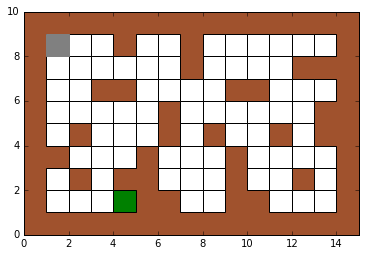

In [3]:
import random

def simpleMazeGenerator(w, h):
    percentage_of_empty_space = 0.75
    
    maze = []
    start_position_set = False
    last_rand_end_position = int(random.random() * (h - 2) + 1)
    
    for i in range(w):
        str = ""
        for j in range(h):
            if i == 0 or i == w-1 or j == 0 or j == h-1:
                str += "#"
            elif i == w - 2 and j == last_rand_end_position:
                str += "X"
            else:
                rand = random.random()
                if rand <= percentage_of_empty_space:
                    if not start_position_set:
                        str += "@"
                        start_position_set = True
                    else:
                        str += "."
                        
                else:
                    str += "#"
                
        maze.append(str)
                
    
    return Maze(maze)

simpleMazeGenerator(10,15).draw()

In [4]:
import copy
from Queue import PriorityQueue

def ta(a,b): # tuple add
    return tuple(map(sum, zip(a,b)))

def est_value(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def heuristic(maze):
    dis = [[10000000 for x in range(len(maze.grid[0]))] for y in range(len(maze.grid))] # Fill with an +INF num
    dis[maze.player_pos[1]][maze.player_pos[0]] = 0
    q = PriorityQueue()
    q.put((0, maze, []))
    
    while not q.empty():
        (prio, front_maze, path) = q.get()
        
        if front_maze.is_at_exit():
            path.pop()
            return path
        
        for move in front_maze.available_moves():
            
            if move is "switch": continue
            
            new_maze = front_maze.clone()

            (dx, dy) = move
            new_maze.move_player(dx, dy)
            (ox, oy) = front_maze.player_pos
            (px, py) = new_maze.player_pos

            if dis[oy][ox] + 1 < dis[py][px]:
                dis[py][px] = dis[oy][ox] + 1
                priority = est_value(new_maze.player_pos, new_maze.exit_pos) + dis[py][px]
                new_path = list(path)
                new_path.append((px, py))
                q.put((priority, new_maze, new_path))

    return [] # No solution found

In [5]:
def maze1():
    return Maze([
        "########",
        "#X.#...#",
        "#.##.#.#",
        "#.#..#.#",
        "#....#.#",
        "#.##...#",
        "#..#..##",
        "##.#..@#",
        "########"
    ])

#maze1().draw()

def maze2():
    return Maze([
        "###############",
        "#X#@.#.#...#..#",
        "#.##.....#....#",
        "#.#.#.#..#..#.#",
        "#...#.#....#..#",
        "#.#.#.........#",
        "#.#.##.#..#...#",
        "#.....#..#..#.#",
        "#####...#.....#",
        "########...####",
        "###############"
    ])

#maze2().draw()

def mazeUnsolvable1():
    return Maze([
        "###############",
        "#X#@.#.#...#..#",
        "#.##.....#....#",
        "#.#.#.#..#..#.#",
        "#.#.#.#....#..#",
        "#..##...#.....#",
        "#.#.##....#...#",
        "#.#...#..#..#.#",
        "#####...#.....#",
        "########...####",
        "###############"
    ])

#mazeUnsolvable1().draw()

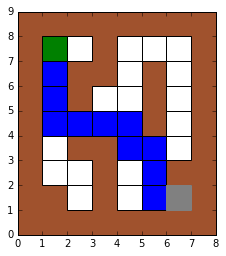

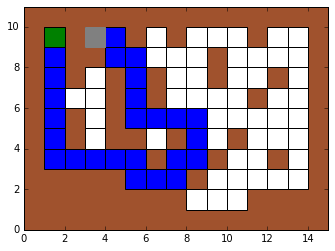

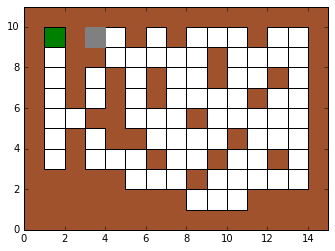

In [6]:
mz1 = maze1()
mz1.set_path(heuristic(mz1))
mz1.draw()

mz2 = maze2()
mz2.set_path(heuristic(mz2))
mz2.draw()

mzu = mazeUnsolvable1()
mzu.set_path(heuristic(mzu))
mzu.draw()

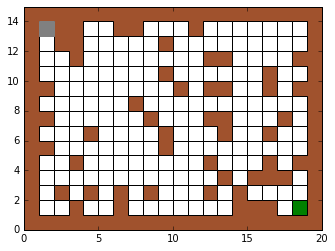

In [7]:
mzs = simpleMazeGenerator(15, 20)
mzs.set_path(heuristic(mzs))
mzs.draw()

You also have to be able to handle switch and door puzzles:

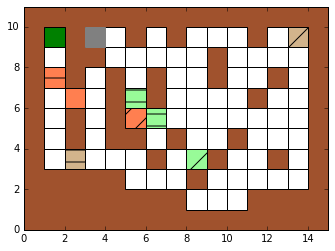

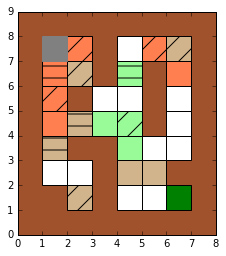

In [8]:
def maze3():
    return Maze([
        "###############",
        "#X#@.#.#...#.1#",
        "#.##.....#....#",
        "#A#.#.#..#..#.#",
        "#.a.#C#....#..#",
        "#.#.#0C.......#",
        "#.#.##.#..#...#",
        "#.B...#.2#..#.#",
        "#####...#.....#",
        "########...####",
        "###############"
    ])

maze3().draw()

def maze4():
    return Maze([
        "########",
        "#@0#.01#",
        "#A1#C#a#",
        "#0#..#.#",
        "#aBc2#.#",
        "#B##c..#",
        "#..#bb##",
        "##1#..X#",
        "########"
    ])

maze4().draw()

In [9]:
def heuristic_switch(maze):
    appeared_maze = set([maze])
    q = PriorityQueue()
    q.put((0, maze, [], 0))
    
    while not q.empty():
        (prio, front_maze, path, cost) = q.get()
        
        if front_maze.is_at_exit():
            path.pop()
            return path
        
        for move in front_maze.available_moves():
            
            new_maze = front_maze.clone()
            
            if move is "switch": 
                new_maze.toggle()
                new_path = list(path)
                if new_maze not in appeared_maze:
                    q.put((priority, new_maze, new_path, cost))
                    appeared_maze.add(new_maze)
                
            else:     
                (dx, dy) = move
                new_maze.move_player(dx, dy)
                (ox, oy) = front_maze.player_pos
                (px, py) = new_maze.player_pos

                priority = est_value(new_maze.player_pos, new_maze.exit_pos) + cost
                new_path = list(path)
                new_path.append((px, py))
                
                if new_maze not in appeared_maze:
                    q.put((priority, new_maze, new_path, cost + 1))
                    appeared_maze.add(new_maze)

    return [] # No solution found

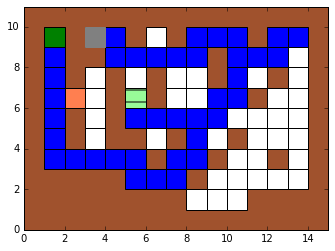

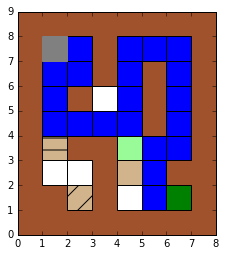

In [10]:
mz3 = maze3()
mz3.set_path(heuristic_switch(mz3))
mz3.draw()

mz4 = maze4()
mz4.set_path(heuristic_switch(mz4))
mz4.draw()

# Assignment 2

Once you have this working, write an agent which finds a policy for a "blind" puzzle using MCTS. "Blind" puzzles are just like the puzzles above, only (a) you don't get to see the whole puzzle or know the goal states in advance, and (b) some nodes are trap doors with a chance of dropping the player into a bottomless pit! Try different policies for deciding between exploit/explore and for doing rollouts and compare them.  Plot graphs on how learning improves with  more rollouts.

Of course, it should also be able to solve the earlier maze puzzles!

In [11]:
import random
from math import sqrt
from numpy import log
from ipywidgets import FloatProgress
from IPython.display import display

iterations_mcts = 0
CP = 0.707

class Tree:

    def __init__(self):
        self.parent = None
        self.children = set()
        self.tried_moves = set()
        self.maze = None
        self.move = None
        self.reward = 0
        self.access_count = 1  # Must be 1 to prevent division-by-zero
        self.depth = 0

    def append(self, sub_tree):
        sub_tree.parent = self
        sub_tree.depth = self.depth + 1
        self.children.add(sub_tree)


def mcts(maze, iterations):
    global iterations_mcts

    tree = Tree()
    tree.maze = maze
    iterations_mcts = iterations

    percentage_loader = -1

    progress_bar = FloatProgress(min=0, max=100)
    display(progress_bar)

    for i in range(iterations):
        if int(i * 100.0 / iterations) != percentage_loader:
            percentage_loader = int(i * 100 / iterations)
            progress_bar.value = percentage_loader

        sub_tree = tree_policy(tree)
        #print(sub_tree.maze.player_pos)
        reward = default_policy(maze.clone(), sub_tree)
        backup(sub_tree, reward)

    path = []
    last_reward = 0
    tree_root = tree
    while tree is not None:
        path.append(tree.maze.player_pos)
        last_reward = tree.reward
        tree = best_child(tree, 0)

    path.pop()
    return (path, last_reward, tree_root)


def tree_policy(tree):
    global CP
    
    while not tree.maze.is_at_exit():
        if len(tree.maze.available_moves()) > len(tree.tried_moves) and len(tree.maze.available_moves()) != 0:
            child = expand(tree)
            if child == None:
                old_tree = tree
                tree = best_child(tree, CP)
                if tree is None: return old_tree
            else:
                return child
        else:
            old_tree = tree
            tree = best_child(tree, CP)
            if tree is None: return old_tree

    return tree


def expand(tree):
    available_moves = tree.maze.available_moves()
    random.shuffle(available_moves)
    for move in available_moves:
        child_maze = tree.maze.clone()

        if move not in tree.tried_moves:
            tree.tried_moves.add(move)
            child_maze = tree.maze.clone()

            if move is "switch":
                child_maze.toggle()
            else:
                child_maze.move_player(move[0], move[1])
            
            tree_lookback = tree.parent
            continue_flag = False
            while tree_lookback != None:
                if tree_lookback.maze == child_maze:
                    continue_flag = True
                    break
                tree_lookback = tree_lookback.parent
                    
            if continue_flag: continue

            child = Tree()
            child.move = move
            child.maze = child_maze
            child.maze.player_alive = True
            tree.append(child)
            return child

def best_child(tree, cp):
    global iterations_mcts

    max_reward = -1
    best = None
    for child in tree.children:
        if child.reward != None:
            reward = child.reward * 1.0 / child.access_count + cp * \
                     sqrt(2 * log(tree.access_count * 1.0) / child.access_count)
            if reward > max_reward:
                best = child
                max_reward = reward

    return best

def default_policy(maze, tree):
    moves = []
    while tree.move is not None:
        moves.append(tree.move)
        tree = tree.parent
    moves.reverse()
    
    #print(moves)
    
    #maze.kill_player()
    for move in moves:
        if move is "switch":
            maze.toggle()
        elif maze.player_alive:
            maze.move_player(move[0], move[1])
        else:
            break
        
    while not maze.is_at_exit() and maze.player_alive:
        move = random.choice(maze.available_moves())
        if move is "switch":
            maze.toggle()
        else:
            maze.move_player(move[0], move[1])

    if maze.is_at_exit():
        return 1
    else:
        return 0


def backup(tree, reward):
    while tree is not None:
        tree.access_count += 1
        tree.reward += reward
        reward *= 0.99
        tree = tree.parent
    return


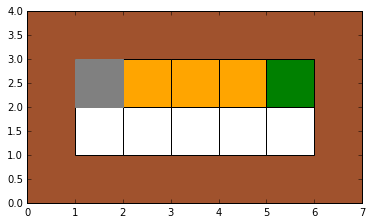

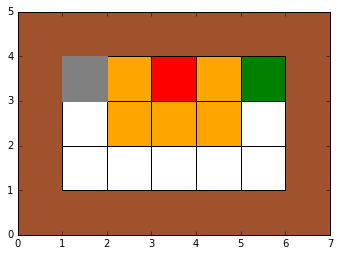

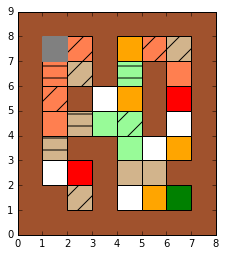

In [12]:
def maze5():
    return Maze([
        "#######",
        "#@???X#",
        "#.....#",
        "#######"
    ])

maze5().draw()

def maze6():
    return Maze([
        "#######",
        "#@?!?X#",
        "#.???.#",
        "#.....#",
        "#######"
    ])

maze6().draw()

def maze7():
    return Maze([
        "########",
        "#@0#?01#",
        "#A1#C#a#",
        "#0#.?#!#",
        "#aBc2#.#",
        "#B##c.?#",
        "#.!#bb##",
        "##1#.?X#",
        "########"
    ])

maze7().draw()

In [ ]:
from __future__ import print_function
import sys

failed = 0

itera = 500
progress_bar = FloatProgress(min=0, max=100)
display(progress_bar)
for i in range(15):
    print("Testing iteration " + `itera` + ": ", end="")
    failed = 0
    for j in range(100):
        mz = maze6()
        data = mcts(mz, itera)
        path = data[0]
        if path != [(1, 3), (1, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (5, 2)]:
            failed += 1
        progress_bar.value = j
            
    print(`(100-failed)` + "% success", end="\n")
    sys.stdout.flush()
    
    itera *= 1.5
    itera = int(itera)

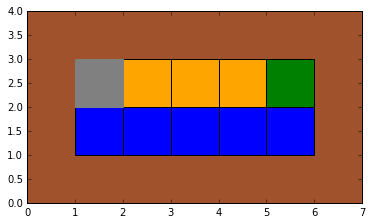

[(1, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]


In [21]:
mzx = maze5()
data = mcts(mzx, 1000)
tree = data[2]
mzx.set_path(data[0])
mzx.draw()
print(data[0])

In [22]:
from __future__ import print_function
f = open('./treedata.txt', 'w+')

def debug_tree(tree, loopc):
    global f
    for i in range(loopc):
        print('-', end="", file=f)
    
    print(`tree.maze.player_pos` + " " + `tree.maze.player_alive` + " " + `tree.reward` + " " + `tree.access_count`, file=f)
    for child in tree.children:
        debug_tree(child, loopc + 1)

debug_tree(tree, 0)

f.close()

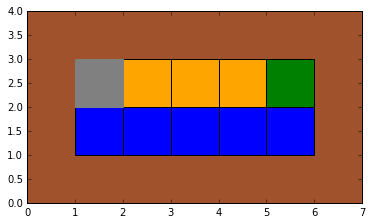

In [17]:
mz5 = maze5()
mz5.set_path(mcts(mz5, 1000)[0])
mz5.draw()

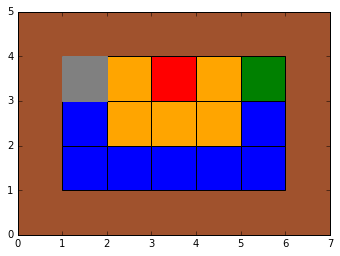

In [18]:
mz6 = maze6()
mz6.set_path(mcts(mz6, 1000)[0])
mz6.draw()

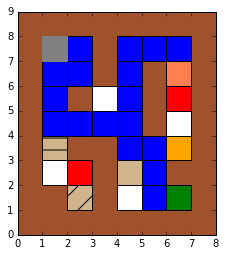

In [24]:
mz7 = maze7()
mz7.set_path(mcts(mz7, 1000000)[0])
mz7.draw()

# Assignment 3

Do assignment 2 again, but with reinforcement learning! Compare various approaches and parameters (e.g.\ state-value learning vs action-value learning, different discounting rates, etc) against your MCTS agents in terms of iterations required to reach certain levels of performance. Plot graphs showing how learning improves with more iterations. Print or draw out (at least some of) the state-value or action-value matrix.

In [42]:
import random
from ipywidgets import FloatProgress
from IPython.display import display

class QLearn:
    
    def __init__(self):
        self.q = {}
        self.epsilon = 0.1
        self.alpha = 0.2
        self.gamma = 0.9
        self.all_actions = ((0,1), (1,0), (0,-1), (-1,0), "switch")
        
    def learn_q(self, state, action, reward, value):
        old_value = self.q.get((state, action), None)
        if old_value is None:
            self.q[(state, action)] = reward
        else:
            self.q[(state, action)] = old_value + self.alpha * (value - old_value)
            
    def choose_action(self, maze):
        if random.random() < self.epsilon:
            action = random.choice(maze.available_moves())
        else:
            q = [self.q.get((maze, act), 0.0) for act in maze.available_moves()]
            max_q = max(q)
            action = random.choice([x for x in maze.available_moves() if self.q.get((maze, x), 0.0) == max_q])
            
        return action
    
    def learn(self, old_maze, action, reward, new_maze):
        max_q = max([self.q.get((new_maze, act), 0.0) for act in self.all_actions])
        self.learn_q(old_maze, action, reward, reward + self.gamma * max_q)

class MazeLearn:
    
    def __init__(self, maze):
        self.maze = maze.clone()
        self.original_maze = maze
        
        self.q_learn = QLearn()
        
        self.last_maze = None
        self.last_action = None
        
    def reset_maze(self):
        self.maze = self.original_maze.clone()
    
    def update(self):
        reward = -1
        
        if not self.maze.player_alive or self.maze.is_at_exit():
            if not self.maze.player_alive:
                self.maze.player_alive = True
                reward = -100
            else:
                reward = 100
                
            if self.last_maze is not None:
                self.q_learn.learn(self.last_maze, self.last_action, reward, self.maze)
            self.last_maze = None
            self.reset_maze()
        else:
            if self.last_maze is not None:
                self.q_learn.learn(self.last_maze, self.last_action, reward, self.maze)
            move = self.q_learn.choose_action(self.maze)
            self.last_maze = self.maze.clone()
            self.last_action = move
            
            if move is "switch":
                self.maze.toggle()
            else:
                self.maze.move_player(move[0], move[1])
            
def rl(maze,iterations):
    # Return the best path (most likely to lead to success) along with its expected value and a validated value
    # for a budget of `iterations` experiments.
    # As above, don't look at maze.exit_pos or maze.grid:
    # you're only allowed to query `maze.available_moves()`, `maze.player_alive`, and `maze.is_at_exit`.

    # After training for `iterations` experiments, run an agent through the maze using that learned policy 
    # for a large number of times and return the average reward:
    # (best_path, expected_reward, test_reward)
    
    learner = MazeLearn(maze)
    
    percentage_loader = -1

    progress_bar = FloatProgress(min=0, max=100)
    display(progress_bar)

    for i in range(iterations):
        if int(i * 100.0 / iterations) != percentage_loader:
            percentage_loader = int(i * 100 / iterations)
            progress_bar.value = percentage_loader
            
            learner.q_learn.epsilon -= 0.001

        learner.update()
    
    #for q,v in learner.q_learn.q.iteritems():
    #    print(`q[0].player_pos` + " " + `q[1]` + " " + `v`)
    
    path = []
    
    old_maze = maze
    maze = maze.clone()
    while not maze.is_at_exit():
        keys = [(maze, move) for move in maze.available_moves()]
        values = [learner.q_learn.q.get(key, -1.0) for key in keys]
        best_value = max(values)
        
        if best_value == -1.0:
            path = ['']
            print "Warning: no solution found"
            break
        
        best_value_key = values.index(best_value)
        move = keys[best_value_key][1]
        
        #print(`maze.player_pos` + " " + `move`)
        
        if move is "switch":
            maze.toggle()
        else:
            path.append(maze.player_pos)
            maze.move_player(move[0], move[1])
            maze.player_alive = True

    maze = old_maze
    path.pop(0)
    return (path,0,0)

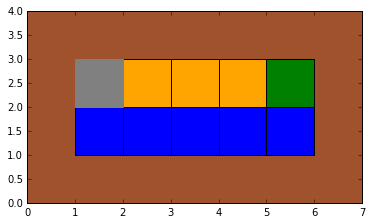

In [40]:
mz5_rl = maze5()
mz5_rl.set_path(rl(mz5_rl, 1000)[0])
mz5_rl.draw()

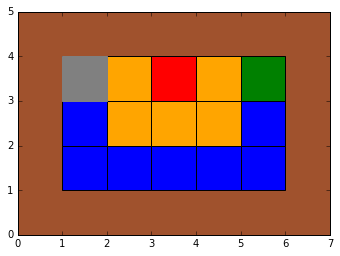

In [41]:
mz6_rl = maze6()
mz6_rl.set_path(rl(mz6_rl, 1000)[0])
mz6_rl.draw()

In [ ]:
mz7_rl = maze7()
mz7_rl.set_path(rl(mz7_rl, 10000000)[0])
mz7_rl.draw()